# Importign required modules

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train transformations
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])

# Test transformations
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 124697705.07it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43216444.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37209819.09it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23432384.71it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Stats
Calculating the mean and standard deviation of the data.

Just for understanding the data.

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


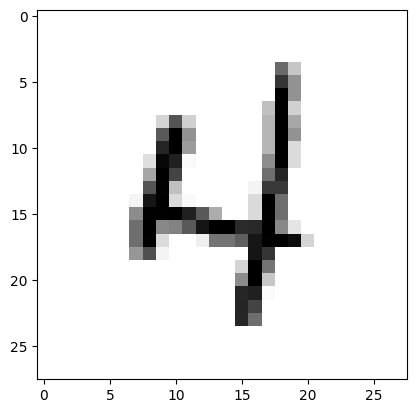

In [5]:
# Convert back tensors back to Numpy
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train data]')
print(' - Numpy Shape:', train_data.numpy().shape)
print(' - Tensor Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

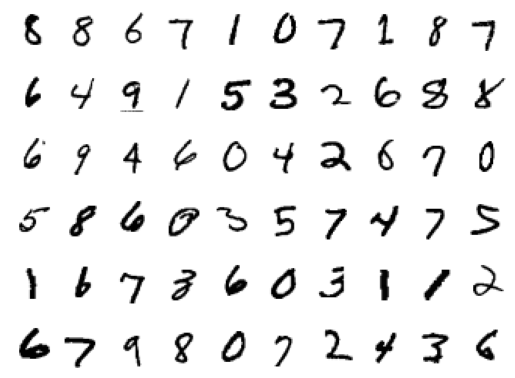

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Data Stats2
The previous block provided statistics for a normalized dataset, resulting in a mean of zero and a standard deviation of one. In this block, we obtain the mean and standard deviation for the raw, unnormalized data.

This step is not necessary if we already have prior knowledge of the mean and standard deviation of the dataset

In [7]:
# simple transform
simple_transforms = transforms.Compose([transforms.ToTensor(),])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp_data.numpy().shape)
print(' - Tensor Shape:', exp_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7


        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU() NEVER!
        ) # output_size = 1 7x7x10 | 7x7x10x10 | 1x1x10

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [19]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

In [20]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [21]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 25
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07084783166646957 Batch_id=468 Accuracy=93.53: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0756, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.09258130937814713 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0588, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.0121193528175354 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]



Test set: Average loss: 0.0427, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.09489065408706665 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:18<00:00, 24.75it/s]



Test set: Average loss: 0.0456, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.0071530998684465885 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0351, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.15721899271011353 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0346, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.0438460111618042 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.020421700552105904 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]



Test set: Average loss: 0.0377, Accuracy: 9884/10000 (98.84%)

EPOCH: 8


Loss=0.021630486473441124 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]



Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.02955307997763157 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]



Test set: Average loss: 0.0298, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.05685814842581749 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.01293382328003645 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.048586513847112656 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.019030524417757988 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.003135640872642398 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.044329676777124405 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.019509008154273033 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]



Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.12%)

EPOCH: 17


Loss=0.02082120068371296 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]



Test set: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

EPOCH: 18


Loss=0.002901884727180004 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.0298, Accuracy: 9900/10000 (99.00%)

EPOCH: 19


Loss=0.003766963491216302 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

EPOCH: 20


Loss=0.12120252102613449 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 23.68it/s]



Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)

EPOCH: 21


Loss=0.03744734451174736 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0297, Accuracy: 9902/10000 (99.02%)

EPOCH: 22


Loss=0.02497410587966442 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 23


Loss=0.01587834022939205 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

EPOCH: 24


Loss=0.0025315938983112574 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)



# Plot the Results

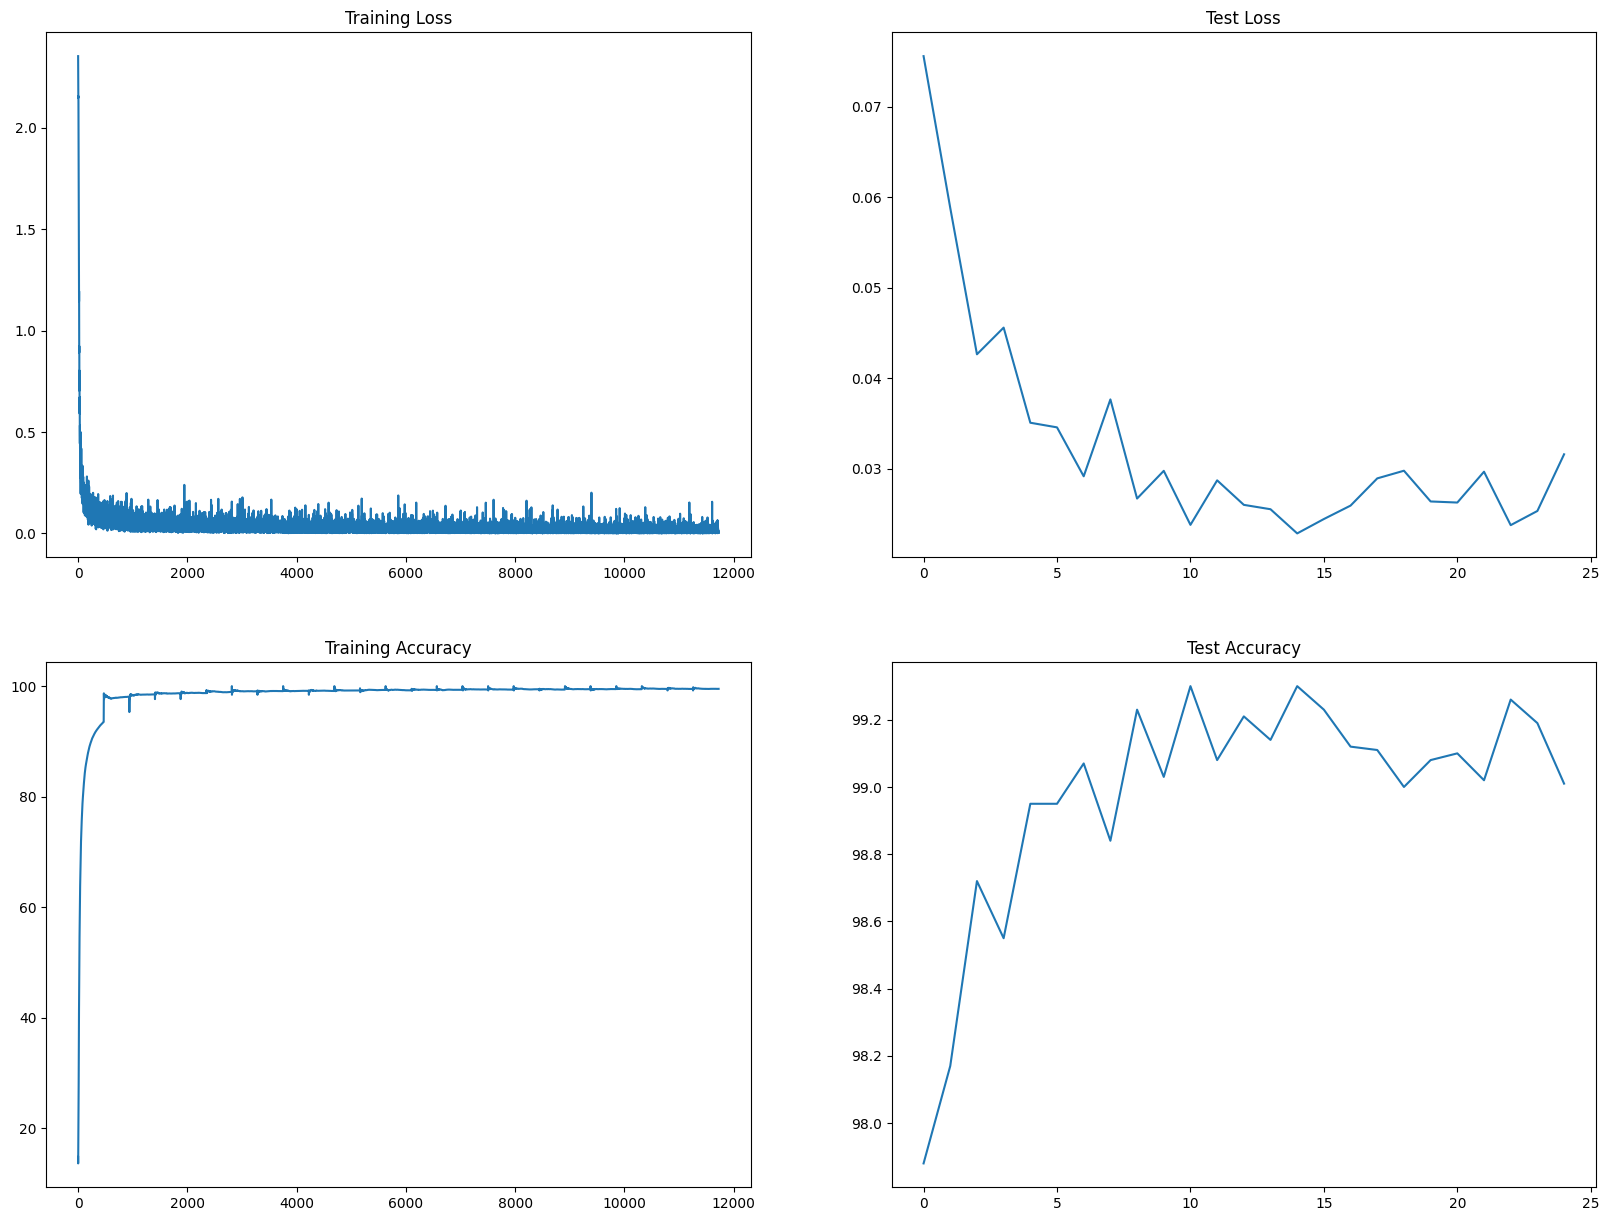

In [22]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(20,15))

axs[0, 0].set_title("Training Loss")
axs[0, 0].plot(t)

axs[1, 0].set_title("Training Accuracy")
axs[1, 0].plot(train_acc)

axs[0, 1].set_title("Test Loss")
axs[0, 1].plot(test_losses)

axs[1, 1].set_title("Test Accuracy")
axs[1, 1].plot(test_acc)

# Iteration 5
---
##Target:
*   Using regularization technique 'Dropout' to reduce the gap between test & train accuracies.

##Results:
*   Total params: 10,970
*   Best Training Accuracy: 99.50%
*   Best Test Accuracy: 99.26%

##Analysis:
*   The gap between the test & train accuracies came down with a bit drop in test accuracy.
*   Not able to push the model performance even after 25th epoch.
*   Dropout did not added any new params to the model